In [100]:
# SN TNS name
tnsname = '2018zz'

# SN discovery date
discovery_date = 58180

# path to directory that contains SN and control light curves
source_dir = '/Users/svoncoelln/Documents/summer2023/2018zz/'

# number of control light curves to load
n_controls = 8

# filter of light curve to analyze
filt = 'o'

# MJD bin size in days of light curve to analyze
mjd_bin_size = 1.0

# define flags that define bad measurements (to filter out bad days in lc)
flags = 0x800000

# note to user: if clean_atlas_lc.py has not been run on the ligth curve to be used here, comment out line 25 in cell 3, which makes reference to a mask column generted through that script. 

In [101]:
import pandas as pd
import numpy as np
import sys,copy,random,math
import scipy.stats as stats
from pdastro import pdastrostatsclass, AandB, AnotB, AorB
from datetime import datetime
from astropy.time import Time
from copy import deepcopy

# plotting
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import pylab as matlib
import warnings
warnings.simplefilter('error', RuntimeWarning)
warnings.filterwarnings("ignore")

# plotting styles
plt.rc('axes', titlesize = 17)
plt.rc('xtick', labelsize = 14)
plt.rc('ytick', labelsize = 14)
plt.rc('legend', fontsize = 12)
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'
#plt.rcParams["image.cmap"] = "viridis"
plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['red', 'orange', 'green', 'blue', 'purple', 'magenta'])
#plt.rc('text', usetex=True)

# for storing lc 
global lc 
lc = pdastrostatsclass()

# for storing info about the lc
global lc_info
lc_info = {}

def load_lc(source_dir, tnsname):
    filename = f'{source_dir}/{lc_info["tnsname"]}.{lc_info["filt"]}.{lc_info["mjd_bin_size"]:0.2f}days.lc.txt'
    print(f'Loading light curve for SN {tnsname} at {filename}...')
    try:
        lc.load_spacesep(filename,delim_whitespace=True)
    except Exception as e:
        print('ERROR: Could not load light curve at %s: %s' % (filename, str(e)))
        sys.exit()
	
    lc_info['baseline_ix'] = lc.ix_inrange(colnames=['MJDbin'], uplim=lc_info['discovery_date']-20, exclude_uplim=True)
    if len(lc_info['baseline_ix'])<=0:
        print('Baseline length is 0! Exiting...')
        sys.exit()
    lc_info['afterdiscdate_ix'] = AnotB(lc.getindices(), lc_info['baseline_ix']) 

lc_info['tnsname'] = tnsname
lc_info['discovery_date'] = discovery_date
lc_info['filt'] = filt
lc_info['mjd_bin_size'] = mjd_bin_size
load_lc(source_dir, tnsname)

Loading light curve for SN 2018zz at /Users/svoncoelln/Documents/summer2023/2018zz//2018zz.o.1.00days.lc.txt...


In [102]:
# define variables, functions to determine values, etc to be used later on

# MJD dates for the ATLAS template changes. t1 is a temporary, estimated value. 
t1 = 57500
t2 = 58417
t3 = 58882

preT1 = inT1 = inT2 = False # Indicates the time range of SN discovery; lacks a T3 option because no correction needs to be done on those SNe.
corrected_T1 = corrected_T2 = corrected_T3 = False # True if the lc was corrected in a given time period.
user_offset_T1 = user_offset_T2 = user_offset_T3 = False # True if the lc was corrected with a user-specified (vs automatic) offset.
too_few_ix_T1 = too_few_ix_T2 = False # True if there are <10 indices available for correction in a region. 

T1_shift_ix, T2_shift_ix, T3_shift_ix = [], [], [] # The indices used to determine offset from expected value.
pre_t1_ix, t1_to_t2_ix, t2_to_t3_ix, post_t3_ix = [], [], [], [] # All indices each time frame.
all_T1_ix, all_T2_ix, all_T3_ix = [], [], [] # Templates overlap, so T3 uses indices from T1 and T2, for instance; chart available at https://imgur.com/a/obPCeUR.

# Values produced by fitting a line to given indices
T1_y_int = T2_y_int = T3_y_int = 0
T1_slope = T2_slope = T3_slope = 0
T1_slope_err = T2_slope_err = T3_slope_err = 0


T1_correction = T2_correction = T3_correction = 0 # The offset of a given set of indices from their expected value
T1_og_mean = T2_og_mean = T3_og_mean = 0 # The original, uncorrected mean of a set of indices. 

good_ix = lc.ix_unmasked('Mask',maskval=flags) # Cut out indices with very high uncertainties; only works if clean_atlas_lc.py has been run. 
today = Time(datetime.now(), format='datetime').mjd


"""
Increase the MJD range of the indices used for correction until there are 40 total measurements, or until all measurements
in the latter half of T2 are in use. If there are fewer than 10 measurements in the final list, set the relevant boolean to True. 
shift_ix: the list to which to add indices 
lim: the maximum limit; new indices are added working backwards from this value 
"""
def last_40_measurements(shift_ix, lim):
    i = 10 
    while (len(shift_ix) < 40):
        if (lim == t3) and (i > (t3-t2)/2): # the upper limit for T2 is t3, and T2 is the smallest region so the loop can't go back too far
            break
        shift_ix = AandB(good_ix, lc.ix_inrange('MJD', lowlim=lim-i, uplim=lim))
        i+=1
    if (len(shift_ix) < 10):
        print("Insufficient indices at the end of the template to perform automatic correction.")
        if (lim == t3):
            global too_few_ix_t2
            too_few_ix_t2 = True
        if (lim == t2):
            global too_few_ix_t1
            too_few_ix_t1 = True
    return shift_ix

"""
Define index ranges for various template statuses; guided by chart available at https://imgur.com/a/obPCeUR. Set the 
appropriate region boolean to true, and define the indices used for automatic correction. 
"""
pre_t1_ix = lc.ix_inrange('MJD', uplim=t1)
t1_to_t2_ix = lc.ix_inrange('MJD', lowlim=t1, uplim=t2)
t2_to_t3_ix = lc.ix_inrange('MJD', lowlim=t2, uplim=t3)
post_t3_ix = lc.ix_inrange('MJD', lowlim=t3)
all_T1_ix = np.concatenate((pre_t1_ix, t1_to_t2_ix))
all_T2_ix = np.concatenate((pre_t1_ix, t1_to_t2_ix, t2_to_t3_ix))
all_T3_ix = np.concatenate((pre_t1_ix, t1_to_t2_ix, t2_to_t3_ix, post_t3_ix))

if (discovery_date < t3 and discovery_date > t2):
    inT2 = True
    T3_shift_ix = lc.ix_inrange('MJD', lowlim=today-365)
    T3_shift_ix = AandB(good_ix, T3_shift_ix)
elif (discovery_date < t2 and discovery_date > t1):
    inT1 = True
    T2_shift_ix = last_40_measurements(T2_shift_ix, t3)
    T3_shift_ix = lc.ix_inrange('MJD', lowlim=today-365)
    T3_shift_ix = AandB(good_ix, T3_shift_ix)
elif (discovery_date < t1):
    preT1 = True
    T1_shift_ix = last_40_measurements(T1_shift_ix, t2)
    T2_shift_ix = last_40_measurements(T2_shift_ix, t3)   
    T3_shift_ix = lc.ix_inrange('MJD', lowlim=today-365)
    T3_shift_ix = AandB(good_ix, T3_shift_ix)

In [103]:
# functions for correction, plotting

"""
Calculate and return the mean flux value of the passed indices, using the passed pdastrostatsclass object.
df: pdastrostatsclass object containing the light curve
shift_ix: the indices whose mean is being calculated
"""
def calc_mean(df, shift_ix):
    df.calcaverage_sigmacutloop('uJy', noisecol='duJy', Nsigma=3, indices=shift_ix, median_firstiteration=True)
    mean = df.statparams['mean']
    return mean

"""
Correct the flux values in a region according either to user input or an automatically calculated correction value.
If the user passes an offset, add that offset to all flux values in the region, and set "corrected" and "user_offset"
for those regions to True. Otherwise, calculate the offset automatically. If the passed shift_ix contains too few datapoints, 
warn the user of this, and do not perform correction. If the passed slope (presumably calulated with the fit_line() 
method) is greater than 3 times the slope error, flux from the supernova has infiltrated the template and makes automatic 
correction impossible. Otherwise, determine the mean, and, if it is negative (as is expected when the template changes mid 
light curve), correct (via subtracting that mean/offset from all indices in the region) that region such that the shift_ix 
mean is at 0. Set the regional correction boolean to True. 
df: pdastrostatsclass object containing the light curve to be corrected
shift_ix: the indices used to calculate the mean/offset
template_ix: all indices in the current region
slope, slope_err: the slope and slope error of shift_ix, presumably calculated by fit_line()
offset: a user-specified offset, ADDED TO (not subtracted from) template_ix flux values; bypasses automatic correction
"""
def template_correction(df, shift_ix, template_ix, slope, slope_err, offset=None): 
    region = ""
    if (np.array_equal(template_ix, post_t3_ix)):
        region = "T3"
    if (np.array_equal(template_ix, t2_to_t3_ix)):
        region = "T2"
    if (np.array_equal(template_ix, t1_to_t2_ix)):
        region = "T1"
    if (offset is None):
        if (region == "T2" and too_few_ix_T2==True) or (region == "T1" and too_few_ix_T1==True):
            print(f"The list passed as 'shift_ix' in {region} contains fewer than 10 indices, which is not enough to perform atomatic correction.")
        elif (slope > 0+3*slope_err):
            print(f"SN flux in the ATLAS template has interefered with measurements in {region} Automatic correction will likely lead to error.")
            print("Slope of the line fitted to the correctional indices (last 40 measurements in T1 and T2, last year of T3):", slope)
            print("Slope error:", slope_err)
        else: 
            offset=calc_mean(df, shift_ix)
            df.calcaverage_sigmacutloop('uJy', noisecol='duJy', Nsigma=3, indices=shift_ix, median_firstiteration=True)
            offset = df.statparams['mean']
            if (offset > 0):
                print(f"Error! Offset from 0 is positive ({offset}), so correction in {region} cannot be done automatically.")
            else:
                print(f"The offset in {region} is {offset}.")
                df.t.loc[template_ix, 'uJy'] -= offset
                if (region == "T3"):
                    global corrected_T3
                    corrected_T3 = True
                if (region == "T2"):
                    global corrected_T2
                    corrected_T2 = True
                if (region == "T1"):
                    global corrected_T1
                    corrected_T1 = True
    else:
        print(f"The offset in {region} is {offset}.")
        df.t.loc[template_ix, 'uJy'] += offset
        if (region == "T3"):
            global user_offset_T3
            corrected_T3 = user_offset_T3 = True
        if (region == "T2"):
            global user_offset_T2
            corrected_T2 = user_offset_T2 = True
        if (region == "T1"):
            global user_offset_T1
            corrected_T1 = user_offset_T1 = True
    return offset
        
"""
Plot the corrected light curve, highlighting indices used to determine offset in red, and corrected indices in purple. 
df: the pdastrostatsclass object containing the light curve
cut_ix: only plot indices in this list; used to cut out values with high uncertainty
shift_ix: indices to highlight in either red or purple, depending on whether they were corrected or simply used for mean calculation
keep_ix: all indices in the plot aside from non-shift indices in the current region
corrected: True if this region has been corrected; if True, highlighted indices become purple 
"""
def plot_two_colored(df, cut_ix, shift_ix, keep_ix, corrected=False):
    shifted_ix = AandB(cut_ix, shift_ix)
    constant_ix = AnotB(cut_ix, keep_ix)
    if (corrected):
        ax1.scatter(df.t.loc[shifted_ix, 'MJD'], df.t.loc[shifted_ix, 'uJy'], s=20, color='xkcd:lilac', marker='o', alpha =1, label=f'Corrected SN Lightcurve')
        ax1.errorbar(df.t.loc[shifted_ix,'MJD'], df.t.loc[shifted_ix,'uJy'], yerr=df.t.loc[shifted_ix,'duJy'], fmt='none', ecolor='xkcd:lilac', elinewidth=1, c='xkcd:lilac', alpha=0.5)
        ax1.scatter(df.t.loc[constant_ix, 'MJD'], df.t.loc[constant_ix, 'uJy'], s=20, color='orange', marker='o', alpha =1, label=f'SN Lightcurve')
        ax1.errorbar(df.t.loc[constant_ix,'MJD'], df.t.loc[constant_ix,'uJy'], yerr=df.t.loc[constant_ix,'duJy'], fmt='none', ecolor='orange', elinewidth=1, c='orange', alpha=0.5)
    else:
        ax1.scatter(df.t.loc[shifted_ix, 'MJD'], df.t.loc[shifted_ix, 'uJy'], s=20, color='red', marker='o', alpha =1, label=f'Indices Used to Find Offset')
        ax1.errorbar(df.t.loc[shifted_ix,'MJD'], df.t.loc[shifted_ix,'uJy'], yerr=df.t.loc[shifted_ix,'duJy'], fmt='none', ecolor='red', elinewidth=1, c='red', alpha=0.5)
        ax1.scatter(df.t.loc[constant_ix, 'MJD'], df.t.loc[constant_ix, 'uJy'], s=20, color='orange', marker='o', alpha =1, label=f'SN Lightcurve')
        ax1.errorbar(df.t.loc[constant_ix,'MJD'], df.t.loc[constant_ix,'uJy'], yerr=df.t.loc[constant_ix,'duJy'], fmt='none', ecolor='orange', elinewidth=1, c='orange', alpha=0.5)

"""
Calculate and return the slope, slope error, and y-intercept for the passed indices. 
"""
def fit_line(shift_ix):
    sumx2=sumx=sumy=sumxy=sumis2=delta=0.0
    inversesigma2 = 1.0/(lc.t.loc[shift_ix, 'duJy']*lc.t.loc[shift_ix, 'duJy'])
    lc.t['Inverse Sigma2'] = inversesigma2
    sumis2 = np.sum(lc.t.loc[shift_ix,'Inverse Sigma2'])
    sumx2 = np.sum(lc.t.loc[shift_ix,'Inverse Sigma2'] * lc.t.loc[shift_ix, 'MJD'] * lc.t.loc[shift_ix, 'MJD'])
    sumx = np.sum(lc.t.loc[shift_ix,'Inverse Sigma2'] * lc.t.loc[shift_ix, 'MJD'])
    sumy = np.sum(lc.t.loc[shift_ix,'Inverse Sigma2'] * lc.t.loc[shift_ix, 'uJy'])
    sumxy = np.sum(lc.t.loc[shift_ix,'Inverse Sigma2'] * lc.t.loc[shift_ix, 'MJD'] * lc.t.loc[shift_ix, 'uJy'])
    delta = sumis2*sumx2 - sumx*sumx
    calc_y_int = 1.0/delta * (sumx2*sumy - sumx*sumxy)
    calc_y_int_err = math.sqrt(1.0/delta * sumx2)
    slope = 1.0/delta * (sumis2*sumxy - sumx*sumy)
    slope_err = math.sqrt(1.0/delta * sumis2)
    return slope, slope_err, calc_y_int

"""
Given an MJD value, find and return a float value representing its position on the x-axis relative to the bounds of 
the axis (0 for the minimum, 1 for the maximum, .5 for an MJD value precisely in the middle of the plot).
xvalue: the MJD value to convert   
"""
def find_xfraction(xvalue):
    minimum = ax1.get_xlim()[0]
    maximum = ax1.get_xlim()[1]
    length = maximum-minimum
    return (xvalue-minimum)/length

"""
Plot a line determined by the passed slope and y-intercept, and bounded within the passed indices.
df: pdastrostatsclass object containing the light curve 
shift_ix: the indices over which the line is to be plotted
slope, y_int: slope and y-intercept of the line to be plotted
dashed: if true, the line will be dashed
"""
def plot_segment_slope(df, shift_ix, slope, y_int, dashed=False):
    if (slope == 0):
        if (dashed): 
            plt.axhline(y=y_int, xmin=find_xfraction(df.t.loc[shift_ix[0], 'MJD']), xmax=find_xfraction(df.t.loc[shift_ix[len(shift_ix)-1], 'MJD']), color='green', zorder=20, linestyle='dashed', linewidth=2, label="Mean of Highlighted Indices")
        else:   
            plt.axhline(y=y_int, xmin=find_xfraction(df.t.loc[shift_ix[0], 'MJD']), xmax=find_xfraction(df.t.loc[shift_ix[len(shift_ix)-1], 'MJD']), color='green', zorder=19, linewidth=2, label="Mean of Highlighted Indices")
    else:
        x = df.t.loc[shift_ix, 'MJD']
        y = slope*x + y_int
        plt.plot(x, y, color='blue', label=f'Slope of Highlighted Indices')

"""
If a region is uncorrected, plot its original mean as a horizontal line across shift_ix. If it was corrected, plot an arrow
from the original mean to the post-correction mean, and a line at the post-correction mean.
df: the pdastrostatsclass object containing the light curve
og_mean: the original mean of shift_ix
offset_amt: the offset from the expected values in a given region, either input by a user or calculated in template_correction()
shift_ix: the indices over which to plot
corrected: True if the current region was corrected
user_offset: True if the user input the correction value in the current region
"""
def plot_offset(df, og_mean, offset_amt, shift_ix, corrected=False, user_offset=False):
    if (corrected):
        if (user_offset):
            plt.arrow(df.t.loc[shift_ix[int(len(shift_ix)/2)], 'MJD'], og_mean, 0, offset_amt, length_includes_head=True, color='blue', width=10, zorder=20)
            plt.axhline(y=og_mean+offset_amt, xmin=find_xfraction(df.t.loc[shift_ix[0], 'MJD']), xmax=find_xfraction(df.t.loc[shift_ix[len(shift_ix)-1], 'MJD']), color='blue', zorder=19)
        else:
            plt.arrow(df.t.loc[shift_ix[int(len(shift_ix)/2)], 'MJD'], og_mean, 0, -offset_amt, length_includes_head=True, color='blue', width=10, zorder=20)
            plt.axhline(y=og_mean-offset_amt, xmin=find_xfraction(df.t.loc[shift_ix[0], 'MJD']), xmax=find_xfraction(df.t.loc[shift_ix[len(shift_ix)-1], 'MJD']), color='blue', zorder=19)
    else:
        plt.axhline(y=og_mean, xmin=find_xfraction(df.t.loc[shift_ix[0], 'MJD']), xmax=find_xfraction(df.t.loc[shift_ix[len(shift_ix)-1], 'MJD']), color='blue', zorder=19, label="Offset of Highlighted Indices")

In [104]:
# [OPTIONAL] set y limits for the plots
ymin = None
ymax = None

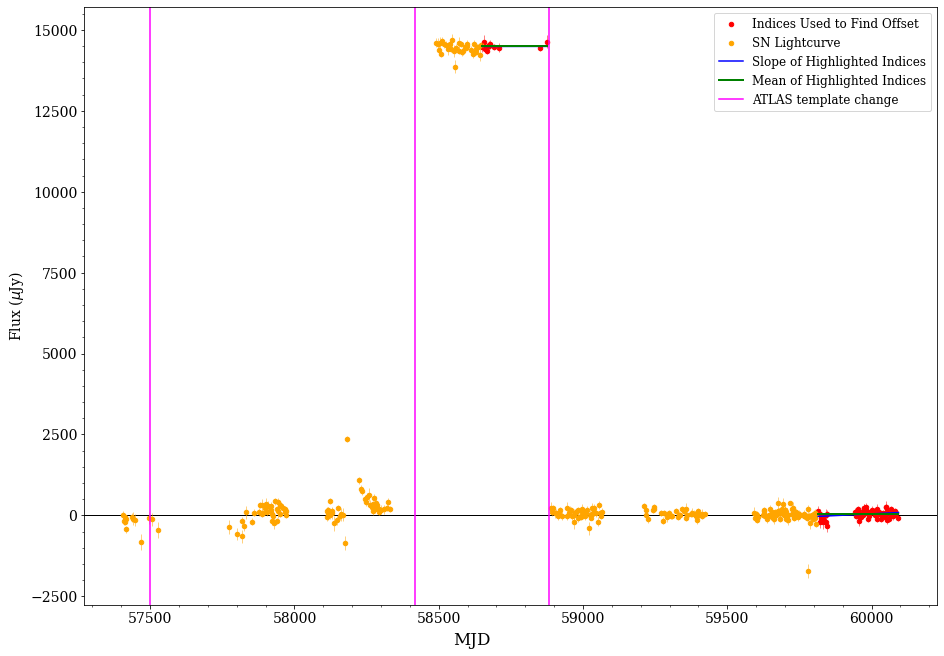

In [105]:
# Plot the uncorrected lc and the ATLAS template changes.  

fig, (ax1) = plt.subplots(1, constrained_layout=True)

fig.set_figwidth(13)
fig.set_figheight(9)
fig.supxlabel('MJD')

# automatically determine y-limits if the user has not input them
if (ymin is not None) and (ymax is not None):
    ax1.set_ylim(ymin, ymax)    
ax1.minorticks_on()    
ax1.set_ylabel(r'Flux ($\mu$Jy)')
ax1.axhline(linewidth=1, color='k', zorder=0)

"""
Calculate the slope, slope error, and y-intercept in each active region, depending on when the SN was discovered. Plot
the light curve, highlighting indices to be used for correction calculations in red. Plot the slope and mean of the
highlighted indices in blue and green, respectively. Store the uncorrected mean in each active region. 
"""
if (inT2):
    T3_slope, T3_slope_err, T3_y_int = fit_line(T3_shift_ix)
    plot_two_colored(lc, good_ix, T3_shift_ix, T3_shift_ix)
    plot_segment_slope(lc, T3_shift_ix, T3_slope, T3_y_int)
    T3_og_mean = calc_mean(lc, T3_shift_ix)
    plot_segment_slope(lc, T3_shift_ix, 0, T3_og_mean)
elif (inT1):
    T2_slope, T2_slope_err, T2_y_int = fit_line(AandB(good_ix, T2_shift_ix))
    T3_slope, T3_slope_err, T3_y_int = fit_line(T3_shift_ix)

    plot_two_colored(lc, good_ix, T2_shift_ix, np.concatenate((T2_shift_ix, post_t3_ix)))
    plot_two_colored(lc, good_ix, T3_shift_ix, np.concatenate((T3_shift_ix, all_T2_ix)))

    plot_segment_slope(lc, T2_shift_ix, T2_slope, T2_y_int)
    plot_segment_slope(lc, T3_shift_ix, T3_slope, T3_y_int)

    T2_og_mean = calc_mean(lc, T2_shift_ix)
    T3_og_mean = calc_mean(lc, T3_shift_ix)
    
    plot_segment_slope(lc, T2_shift_ix, 0, T2_og_mean)
    plot_segment_slope(lc, T3_shift_ix, 0, T3_og_mean)
if (preT1):
    T1_slope, T1_slope_err, T1_y_int = fit_line(T1_shift_ix)
    T2_slope, T2_slope_err, T2_y_int = fit_line(T2_shift_ix)
    T3_slope, T3_slope_err, T3_y_int = fit_line(T3_shift_ix)

    plot_two_colored(lc, good_ix, T1_shift_ix, np.concatenate((T1_shift_ix, t2_to_t3_ix, post_t3_ix)))
    plot_two_colored(lc, good_ix, T2_shift_ix, np.concatenate((T2_shift_ix, all_T1_ix, post_t3_ix)))

    plot_segment_slope(lc, T1_shift_ix, T1_slope, T1_y_int)
    plot_segment_slope(lc, T2_shift_ix, T2_slope, T2_y_int)
    plot_segment_slope(lc, T3_shift_ix, T3_slope, T3_y_int)

    T1_og_mean = calc_mean(lc, T1_shift_ix)
    T2_og_mean = calc_mean(lc, T2_shift_ix)
    T3_og_mean = calc_mean(lc, T3_shift_ix)

    plot_segment_slope(lc, T1_shift_ix, 0, T1_og_mean)
    plot_segment_slope(lc, T2_shift_ix, 0, T2_og_mean)
    plot_segment_slope(lc, T3_shift_ix, 0, T3_og_mean)
    

for i in [t1, t2, t3]: 
    plt.axvline(x=i, color='magenta', label='ATLAS template change')

# prevent duplicate lables in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), loc='upper right')

In [106]:
# manually set offset in regions of choice  

T1_user_offset = None
T2_user_offset = None
T3_user_offset = None

In [107]:
today = Time(datetime.now(), format='datetime').mjd

temp_lc = deepcopy(lc) # from now on, a copy of the lc is used, so that corrections will not accumulate if the program is rerun without re-importing the lc. 

"""
Set the appropriate discovery region boolean to true, and get the offset from expected values in a region via template_correction(),
which returns the user-specified value if there is one, and the automatically calculated one if there is not. 
"""
if (discovery_date < t3 and discovery_date > t2):
    inT2 = True
    T3_correction = template_correction(temp_lc, T3_shift_ix, post_t3_ix, T3_slope, T3_slope_err, T3_user_offset)
elif (discovery_date < t2 and discovery_date > t1):
    inT1 = True
    T2_correction = template_correction(temp_lc, T2_shift_ix, t2_to_t3_ix, T2_slope, T2_slope_err, T2_user_offset)
    T3_correction = template_correction(temp_lc, T3_shift_ix, post_t3_ix, T3_slope, T3_slope_err, T3_user_offset)
elif (discovery_date < t1):
    preT1 = True
    T1_correction = template_correction(temp_lc, T1_shift_ix, t1_to_t2_ix, T1_slope, T1_slope_err, T1_user_offset)
    T2_correction = template_correction(temp_lc, T2_shift_ix, t2_to_t3_ix, T2_slope, T2_slope_err, T2_user_offset)
    T3_correction = template_correction(temp_lc, T3_shift_ix, post_t3_ix, T3_slope, T3_slope_err, T3_user_offset)


Error! Offset from 0 is positive (14488.846101515892), so correction in T2 cannot be done automatically.
Error! Offset from 0 is positive (43.51542167512347), so correction in T3 cannot be done automatically.


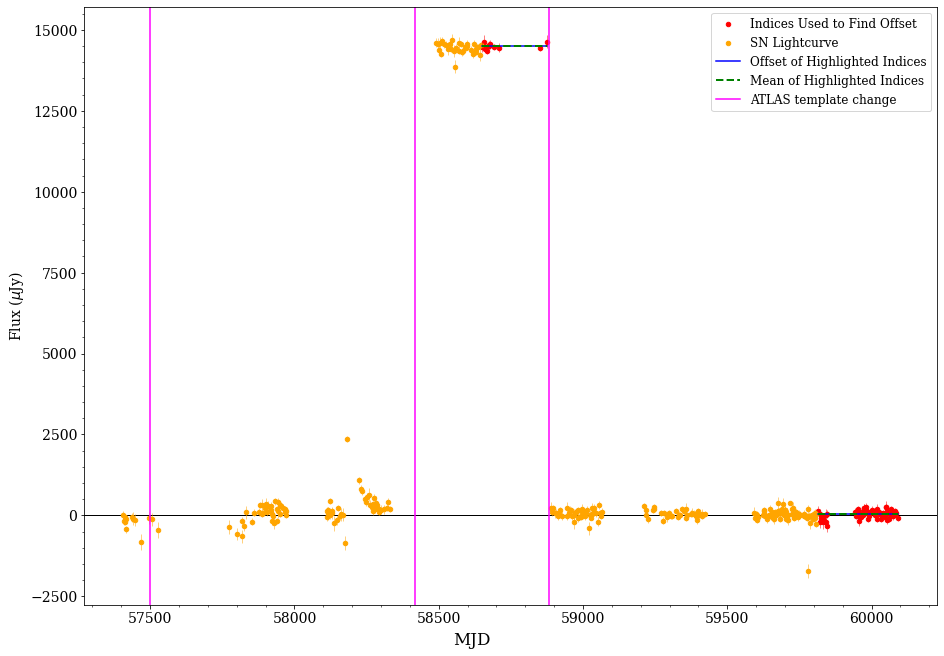

In [108]:
# Plot the corrected light curve. 

fig, (ax1) = plt.subplots(1, constrained_layout=True)

fig.set_figwidth(13)
fig.set_figheight(9)
fig.supxlabel('MJD')

# automatically determine y-limits if the user has not input them
if (ymin is not None) and (ymax is not None):
    ax1.set_ylim(ymin, ymax)  
ax1.minorticks_on()    
ax1.set_ylabel(r'Flux ($\mu$Jy)')
ax1.axhline(linewidth=1, color='k', zorder=0)

"""
Plot the lc, highlighting indices used to calculate correction values in red if no correction was performed, and in purple 
if that region has been corrected (the entire corrected region does not become purple, just the indices used to find the value).
Plot the original mean in each active region, and an arrow indicating the magnitude of the correction, where applicable. (If the
correction distance is less than the length of the arrow head, it may not appear, or may jut out backwards, due to how 
matplotlib.arrow() handles that situation.)
"""
if (inT2):
    plot_two_colored(temp_lc, good_ix, T3_shift_ix, T3_shift_ix, corrected=corrected_T3)
    plot_offset(temp_lc, T3_og_mean, T3_correction, T3_shift_ix, corrected=corrected_T3, user_offset=user_offset_T3)
    plot_segment_slope(temp_lc, T3_shift_ix, 0, T3_og_mean, dashed=True)
elif (inT1):
    plot_two_colored(temp_lc, good_ix, T2_shift_ix, np.concatenate((T2_shift_ix, post_t3_ix)), corrected=corrected_T2)
    plot_two_colored(temp_lc, good_ix, T3_shift_ix, np.concatenate((T3_shift_ix, all_T2_ix)), corrected=corrected_T3)
    plot_offset(temp_lc, T2_og_mean, T2_correction, T2_shift_ix, corrected=corrected_T2, user_offset=user_offset_T2)
    plot_offset(temp_lc, T3_og_mean, T3_correction, T3_shift_ix, corrected=corrected_T3, user_offset=user_offset_T3)
    plot_segment_slope(temp_lc, T2_shift_ix, 0, T2_og_mean, dashed=True)
    plot_segment_slope(temp_lc, T3_shift_ix, 0, T3_og_mean, dashed=True)
if (preT1):
    plot_two_colored(temp_lc, good_ix, T1_shift_ix, np.concatenate((T1_shift_ix, t2_to_t3_ix, post_t3_ix)), corrected=corrected_T1)
    plot_two_colored(temp_lc, good_ix, T2_shift_ix, np.concatenate((T2_shift_ix, all_T1_ix, post_t3_ix)), corrected=corrected_T2)
    plot_two_colored(temp_lc, good_ix, T3_shift_ix, np.concatenate((T3_shift_ix, all_T2_ix)), corrected=corrected_T3)
    plot_offset(temp_lc, T1_og_mean, T1_correction, T1_shift_ix, corrected=corrected_T1, user_offset=user_offset_T1)
    plot_offset(temp_lc, T2_og_mean, T2_correction, T2_shift_ix, corrected=corrected_T2, user_offset=user_offset_T2)
    plot_offset(temp_lc, T3_og_mean, T3_correction, T3_shift_ix, corrected=corrected_T3, user_offset=user_offset_T3)
    plot_segment_slope(temp_lc, T1_shift_ix, 0, T1_og_mean, dashed=True)
    plot_segment_slope(temp_lc, T2_shift_ix, 0, T2_og_mean, dashed=True)
    plot_segment_slope(temp_lc, T3_shift_ix, 0, T3_og_mean, dashed=True)

for i in [t1, t2, t3]: 
    plt.axvline(x=i, color='magenta', label='ATLAS template change')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), loc='upper right') # need to note somewhere that if no arrow appears thats because the head length is longer than the span of arrow 
